This notebook is intended to introduce and demonstrate some of the features of pyMAISE and examine the performance of machine learning models on a common nuclear engineering application. For further information on the capabilities of the classes and functions shown in this notebook, please refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).


# Critical Heat Flux (CHF) Prediction

**Inputs**

- `D`: Diameter of the test section (0.002 - 0.16 $m$) 
- `L`: Heated length (0.07 - 15.0 $m$)
- `P`: Pressure (100 - 20,000 $kPa$)
- `G`: Mass flux (17.7 - 7712.0 $\frac{kg}{m^2.s}$)
- `Tin`: Inlet temperature length (9.0 - 353.62 $\degree C$)
- `X`: Outlet equilibrium quality (-0.445 - 0.986)

**Output**

- `CHF`: Critical Heat Flux (130.0 - 13345.0 $\frac{kW}{m^2}$)

The CHF dataset was taken from the Nuclear Regulatory Commission CHF database. This dataset was generated from vertical water-cooled uniformly heated tubes producing 24,579 samples from 59 different sources of measurements. The dataset was collected over experimental measurements spanning 60 years of CHF data collection methods such as visual identification, physical burnout, changes in the test section resistances, and the usage of thermocouples. The parameters collected consist of pressure ($P$), test section diameter ($D$), heated length ($L$), mass flux ($G$), inlet temperature ($T_{in}$), outlet equilibrium quality ($X$), and $CHF$. 

Negative quality $X$ could represent a subcooled fluid. The database was limited in terms of diameter (2 $<$ D $<$ 25 mm), $L/D$ ratio ($L/D$ $>$ 50 for X $>$ 0, $L/D$ $>$ 25 for X $<$ 0), pressure (100 $\leq$ P $\leq$ 21,000 kPa) and mass flux (0 $\leq$ G $<$ 8,000 kg/m2/s). The measured data was also not equally distributed over the whole span along with no data beyond $D$ = 16 mm was found in the database. **Our goal is to identify optimal ML models with pyMIASE that can predict CHF accurately given other geometrical parameters and boundary conditions ($D, L, P, G, T_{in}, X$).**

**Important Note**: As this dataset is confidential, it is not open-sourced with pyMAISE and can be requested directly from the OECD Nuclear Energy Agency (NEA). In this notebook, we provide 2500 synthetic samples that mimic the real ones (split into 2000 train and 500 test samples). The synthetic samples were generated by adding random noise to the real experiments. The user only needs to replace the synthetic csv files below with the ones from NEA. More information about the benchmark can be found in this link: https://www.oecd-nea.org/jcms/pl_89619/benchmark-on-artificial-intelligence-and-machine-learning-for-scientific-computing-in-nuclear-engineering-phase-1-critical-heat-flux-exercise-specifications?details=true

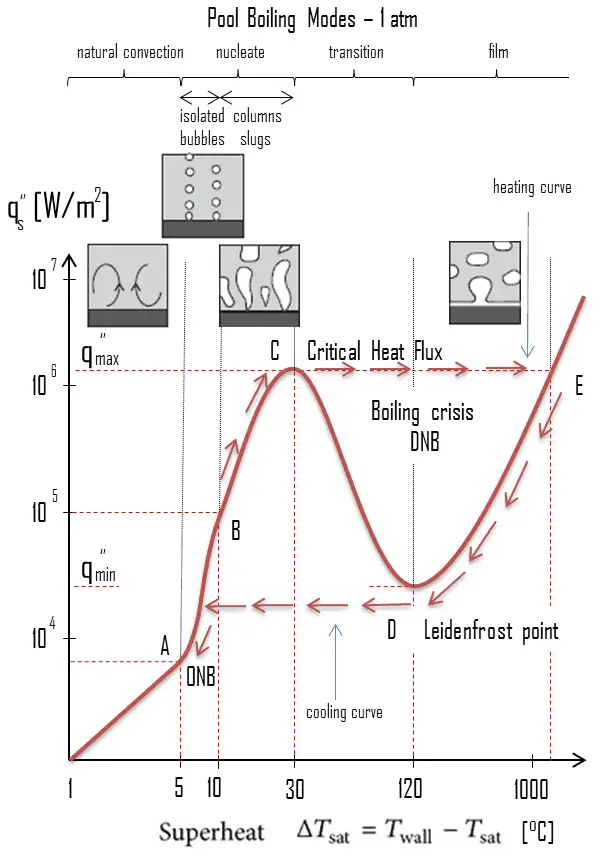

The following are a few standard packages and functions that will prove helpful while using pyMAISE along with pyMAISE-specific functionality. 

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
np.random.seed(42)

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

We need to import several functions and classes for machine learning tuning and analysis with pyMAISE. In this notebook, as we mentioned before, we use a synthetic version of the CHF dataset. We must split the data into training/testing data and scale it. For this, we use the `pyMAISE.preprocessing` Python module. The remaining classes we can get from `pyMAISE` directly which we import as `mai` for convenience.

In [2]:
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

## pyMAISE Initialization

Starting any pyMAISE job requires initialization. This includes the definition of global settings used throughout pyMAISE. These settings and their defaults include:

- `problem_type`: the problem type, either regression or classification, defined by `pyMAISE.ProblemType`,
- `verbosity=0`: the level of output from pyMAISE,
- `random_state=None`: the seed for the random number generator, which can be used to get reproducible results from pyMAISE,
- `num_configs_saved=5`: the number of top hyperparameter configurations for each model evaluated during tuning,
- `new_nn_architecture=True`: a boolean that dictates whether to use the old deprecated pyMAISE neural network tuning architecture,
- `cuda_visible_devices=None`: sets the `CUDA_VISIBLE_DEVICES` environment variable.

The only argument that needs to be specified is `problem_type`. We also pass `"-1"` to `cuda_visible_devices` to ensure we only use tensorflow on the CPU. This is useful for this problem since we will build relatively simple, dense feedforward neural networks with a reasonably small data set. Therefore, running tensorflow on a GPU may hurt our performance. We leave the others default, giving us five hyperparameter configurations for each model, keeping the stochastic nature of some of the algorithms, and using the current neural network hyperparameter tuning architecture.

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

## Data Loading and Preprocessing

pyMAISE has several benchmarked data sets, such as this CHF synthetic data set. Each data set has an accompanying load function. Most load functions return three `xarray.DataArrays`: the raw, input, and output data. You can load personal data using the `pyMAISE.preprocessing.read_csv` function. Refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) for specifics on the use of this function. Loading the CHF synthetic data gives the following data:

In [4]:
from pyMAISE.preprocessing import read_csv


data_train, inputs_train, outputs_train = read_csv("chf_train.csv",
                                slice(0,6), slice(6,7))

data_valid, inputs_valid, outputs_valid = read_csv("chf_valid.csv",
                               slice(0,6), slice(6,7))


The CHF data set has six inputs listed below along with the first sample in the training set

In [5]:
feature_names = inputs_train['variable'].values
output_names = outputs_train['variable'].values

print(f'Feature Names: {feature_names}')
print(f'Output Names: {output_names}')

Feature Names: ['D (m)' 'L (m)' 'P (kPa)' 'G (kg m-2s-1)' 'Tin (C)' 'Xe (-)']
Output Names: ['CHF (kW m-2)']


The CHF data set has one output which is basically the CHF value; the first output sample in the training set is listed below

In [6]:
print(outputs_train['variable'].values)
print(outputs_train.values[0,:])

['CHF (kW m-2)']
[568.]


The shape of the input and output data for both the training and test sets are listed below

In [7]:
print('Training input and output shapes:', inputs_train.shape, outputs_train.shape)
print('Testing input and output shapes:', inputs_valid.shape, outputs_valid.shape)

Training input and output shapes: (16090, 6) (16090, 1)
Testing input and output shapes: (5363, 6) (5363, 1)


To get a better understanding of this data set lets plot a correlation matrix of the data using `pyMAISE.preprocessing.correlation_matrix`.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

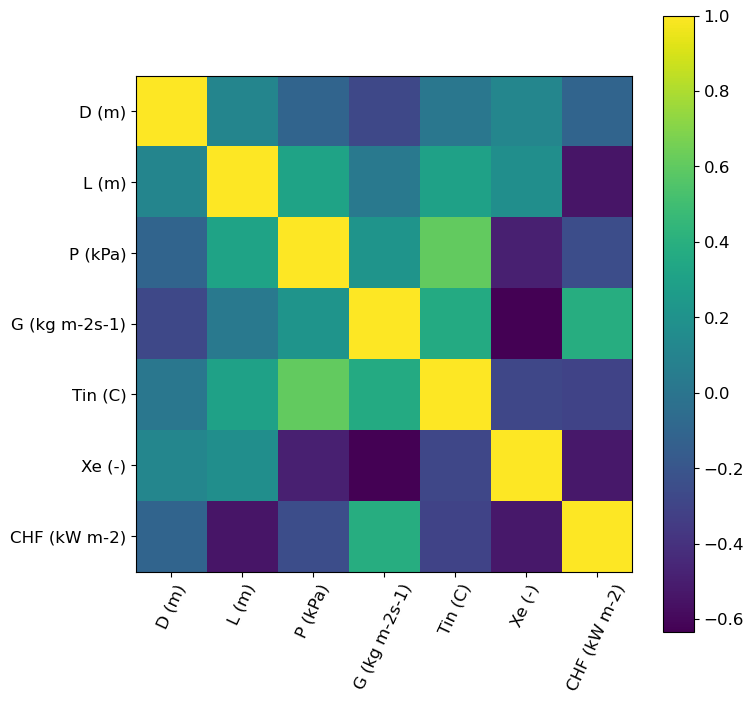

In [8]:
correlation_matrix(data_train)

A large positive correlation can be seen between P and Tin and negative correlation can be found between CHF and L.

With the data loaded, we can now preprocess it. This includes scaling the inputs and outputs since the data were split already. We can scale the data using `pyMAISE.preprocessing.scale_data` with any object that supports `fit_transform` and `transform` functions. Common scalers include [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler). Many machine learning models learn best with scaled data. We use min-max scaling on both the input and output data for this data set. `pyMAISE.preprocessing.scale_data` returns the scaled data, and the scaler fits the data. These scalers are used in postprocessing to evaluate the performance of the models.

In [9]:
# we just define more convenient names for the training and testing variables

ntrain=5000
pick_indices = np.random.randint(0, inputs_train.shape[0], size=ntrain)
xtrain, xtest, ytrain, ytest = inputs_train, inputs_valid, outputs_train, outputs_valid

#scale the data
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [10]:
print('Reduced training input and output shapes:', xtrain.shape, ytrain.shape)
print('Full training input and output shapes:', inputs_train.shape, outputs_train.shape)

Reduced training input and output shapes: (16090, 6) (16090, 1)
Full training input and output shapes: (16090, 6) (16090, 1)


## Model Initialization

For model initialization and tuning, we use the `pyMAISE.Tuner`. pyMAISE supports both classical ML methods with [scikit-learn](https://scikit-learn.org/stable/index.html) and sequential neural networks with [Keras](https://keras.io/). We strongly recommend you refer to `pyMAISE.Tuner` in the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) for a list of supported models, neural network layers, and other information crucial for optimal tuning. We can define all the models we wish to hyperparameter tune using a dictionary. For the this data set, we define the following regression models with their dictionary keys:

- linear: `"Linear"`,
- lasso: `"Lasso"`,
- decision tree: `"DT"`,
- random forest: `"RF"`,
- k-nearest neighbors: `"KN"`,
- feedforward neural network: `"FNN"`.

pyMAISE uses the dictionary keys for classical models to determine which [scikit-learn](https://scikit-learn.org/stable/index.html) model you request. If the keys do not match any supported keys, then it is assumed to be a neural network. In the `"models"` key, we define these models in a list. We can then define the hyperparameters for classical models, which will remain constant throughout tuning. These parameters must only be defined if you want something different from the default. Refer to the model documentation in [scikit-learn](https://scikit-learn.org/stable/index.html) for hyperparameters and defaults.

For the neural network model, we need to define the architecture, optimizer, compiling, and fitting parameters under the `"structural_params"`, `"optimizer"`, `"compile_params"`, and `"fitting_params"` keys. These parameters include those that remain constant and change during tuning. To define hyperparameters for tuning, we use the `pyMAISE.Int`, `pyMAISE.Float`, `pyMAISE.Choice`, `pyMAISE.Boolean`, and `pyMAISE.Fixed` classes. These classes are wrappers for [KerasTuner](https://keras.io/keras_tuner/). 

To define the model architecture, we use the supported Keras layers defined in the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html) under the `pyMAISE.Tuner`. These layers must differ in name, but use the base layer name. Within the layers, pyMAISE supports additional hyperparameters, which include `"sublayer"`, `"wrapper"`, and `"num_layers"` to define sublayers, wrappers (such as [keras.layers.TimeDistributed](https://keras.io/api/layers/recurrent_layers/time_distributed/)), and the number of layers.

We can then pass all this information to `pyMAISE.Tuner`.

In [11]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=250),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([16, 32, 64]),
            "epochs": 30,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

Hyperparameter tuning is split into two options: classical model and neural network tuning. For the classical models, pyMAISE supports grid, random, and Bayesian search. For the neural network models, pyMAISE supports grid, random, Bayesian, and hyperband search. All search methods use cross-validation.

We define the hyperparameter search space for the classical models by defining the arrays, distributions, or [skopt.space.space](https://scikit-optimize.github.io/stable/modules/classes.html#module-skopt.space.space) for each hyperparameter we plan to tune. We describe these within subdictionaries within the model keys. For this problem, we use `pyMAISE.Tuner.random_search` with 200 iterations as the data set is relatively small and the classical models are computationally cheap. For these models, we define the search space using [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

We do not hyperparameter tune linear regression because the hyperparameter options are limited, and the default scikit-learn model performs well on linear problems.

Since we have already defined the feedforward neural network search space in the previous section, all we need to do is call the search method function. For these NNs, we can call `pyMAISE.Tuner.nn_bayesian_search` with 50 iterations as NNs tend to be more computationally expensive to train over the classical models, and the Bayesian optimization may converge on the optimal model with fewer iterations.

We set `cv` for both methods to 5, which gives us five cross-validation splits for each model. This will avoid overfitting. Therefore, for each classical model, we run 1000 hyperparameter configurations, and for the neural networks, we run 250 hyperparameter configurations.

In [12]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=2, 
    cv=2,
)

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=1,
    cv=2,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 0.754509703318278 minutes to process.


After the training, we can see training results for each iteration using the `pyMAISE.Tuner.convergence_plot` function. For the neural networks, we have the following: 

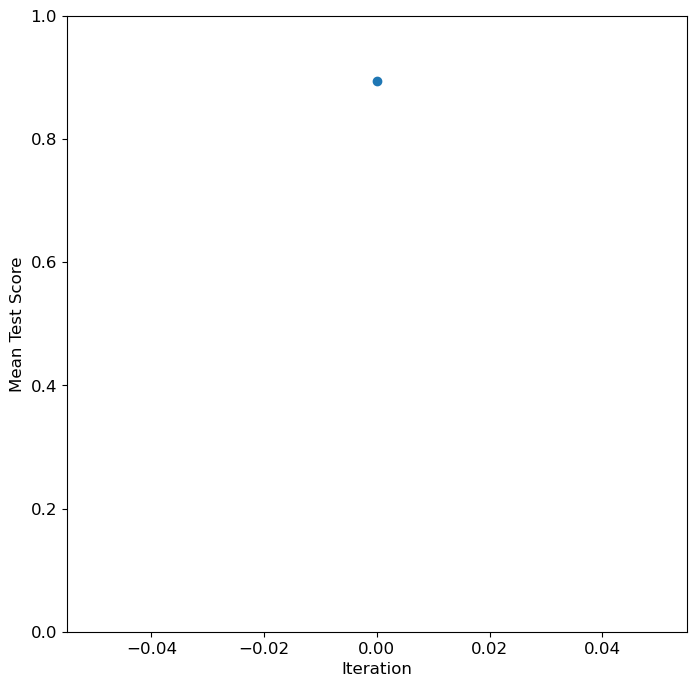

In [13]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.savefig('conv_plot.png', dpi=300, bbox_inches='tight')

The Bayesian search explores the search space but finds several suitable hyperparameter configurations.

## Model Postprocessing

With the models tuned and the top `pyMAISE.Settings.num_configs_saved` saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. Additionally, we can update some hyperparameters after tuning. For this data set, we changed the number of FNN epochs to 200 since we are only running five models. We give the `pyMAISE.PostProcessor` all the scaled data, the model configurations, the new model settings, and the output scaler.

In [14]:


postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 300}},
    },
    yscaler=yscaler,
)

We can now evaluate the performance of the models using the `pyMAISE.PostProcessor.metrics` function. This returns an ordered table with training and testing performance metrics. By default, `pyMAISE.PostProcessor.metrics` evaluates the training and testing $R^2$, mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE) for regression problems. The table is sorted by descending testing $R^2$. We can also add additional metrics, sort by a different metric, or choose the output pyMAISE computes the metrics with. Since we have a single output (CHF), we only need to compute the metrics for this output. For further functionality on `pyMAISE.PostProcessor.metrics` refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

In [15]:
postprocessor.metrics().to_csv('model_metrics.csv', index=False)
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
5,RF,"{'criterion': 'poisson', 'max_features': 'log2...",0.988327,87.570513,6.135539,152.253346,9.945013,0.986511,100.374461,6.617420,153.084530,9.205068
7,KN,"{'leaf_size': 3, 'n_neighbors': 5, 'p': 1, 'we...",0.989536,78.434807,5.113862,144.153753,8.513771,0.984473,95.573894,5.777196,164.238420,8.733079
6,RF,"{'criterion': 'squared_error', 'max_features':...",0.984693,101.984352,7.267315,174.346203,12.008469,0.983521,110.703203,7.419110,169.201553,10.582014
9,FNN,"{'Dense_input_0_units': 102, 'Dense_input_0_su...",0.972853,139.266216,12.212882,232.184192,25.487349,0.977249,129.418984,10.335172,198.809229,19.253516
8,KN,"{'leaf_size': 15, 'n_neighbors': 8, 'p': 4, 'w...",1.000000,0.000808,0.000035,0.043072,0.001809,0.977143,108.124979,6.457766,199.271911,10.087739
4,DT,"{'max_depth': 39, 'max_features': 'log2', 'min...",0.960838,172.182264,11.395863,278.872561,16.962854,0.950270,189.083560,12.066096,293.932503,16.849697
3,DT,"{'max_depth': 8, 'max_features': 6, 'min_sampl...",0.946594,229.366691,16.770990,325.663313,25.126162,0.930401,247.480993,16.546917,347.726286,22.804613
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.699989,547.673668,55.082388,771.867305,112.360333,0.717062,513.733712,45.839505,701.104354,82.256997
1,Lasso,{'alpha': 0.0011336008845060064},0.687045,536.474266,48.809478,788.342285,90.749834,0.703440,504.588417,41.016496,717.783854,67.289358
2,Lasso,{'alpha': 0.007030339300443834},0.270390,832.947294,82.213338,1203.702057,132.893241,0.273166,800.168212,74.674467,1123.711309,118.059316


This data set is very linear, with fantastic performance from linear and lasso regression. The FNNs proved to be marginally better-performing models over the linear classical models; however, this is at the cost of complexity. K-nearest neighbor, random forest, and decision tree struggled on this data set with all three overfittings.

Using the `pyMAISE.PostProcessor.get_params` function, we can see all the top performing (based on test $R^2$) models' hyperparameters.

In [16]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.0011336008845060064

Model Types: DT
max_depth: 39
max_features: log2
min_samples_leaf: 14
min_samples_split: 14

Model Types: RF
criterion: poisson
max_features: log2
min_samples_leaf: 6
min_samples_split: 17
n_estimators: 115

Model Types: KN
leaf_size: 3
n_neighbors: 5
p: 1
weights: uniform

Model Types: FNN
Dense_input_0_units: 102
Dense_input_0_sublayer: Dropout
Dense_input_0_sublayer_Dropout_0_rate: 0.4966111991990583
Dense_hidden_num_layers: 1
Adam_learning_rate: 0.0004968780539989446
Dense_hidden_0_units: 25
Dense_hidden_0_sublayer: Dropout_hidden
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.4
batch_size: 16



Note parameters such as `Dense_input_0_sublayer_Dropout_0_rate` have a value despite `Dense_input_0_sublayer="None"`. This is a product of the hyperparameter recording of KerasTuner. Even though `Dense_input_0_sublayer_Dropout_0_rate` has a value, there does not exist a `Dense_input_0_sublayer_Dropout_0` layer in the top performing FNN model.

We can use the `pyMAISE.PostProcessor.diagonal_validation_plot` and `pyMAISE.PostProcessor.validation_plot` functions to visualize the performance of these models. Diagonal validation plots show the actual versus predicted outcome. A well-performing model follows $y=x$ on this plot. You can choose what outputs to display on the diagonal validation plot; however, since all outputs have the same units, we can display all of them. Both functions use the top-performing model on test $R^2$ by default.

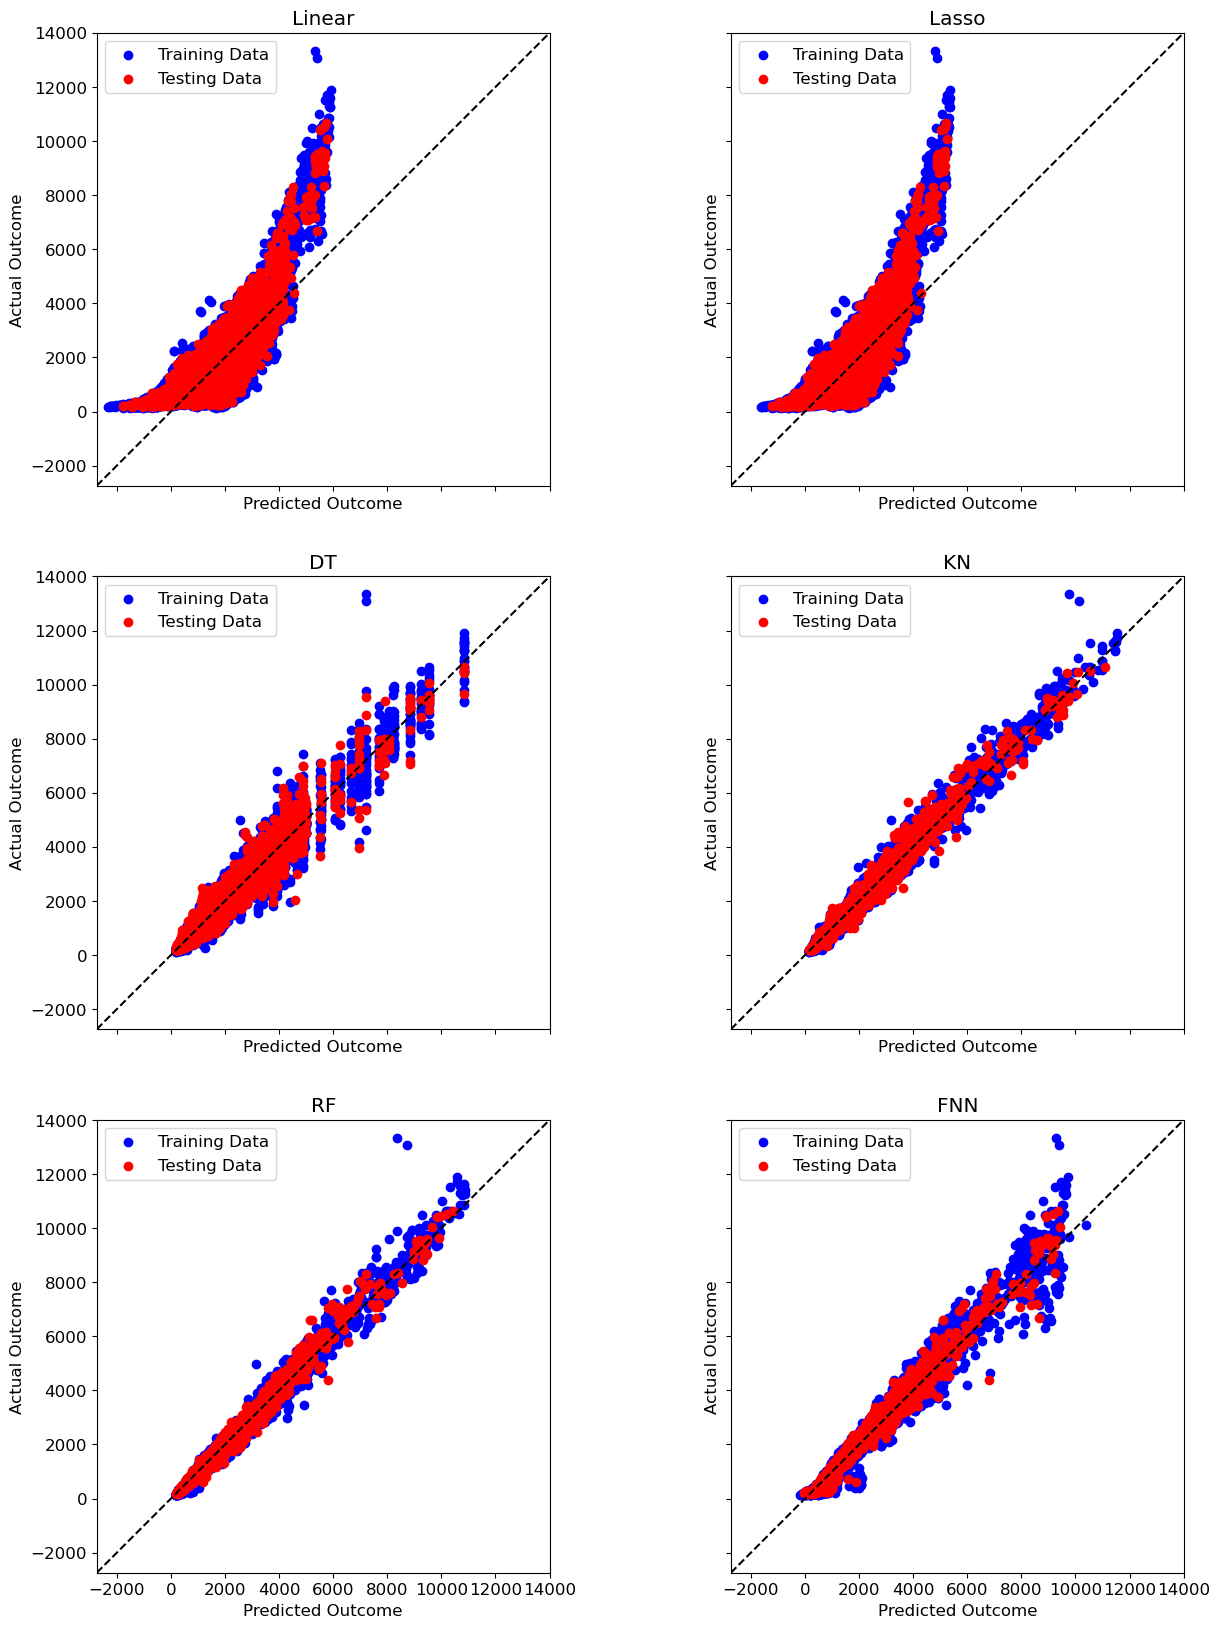

In [17]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
y = ["kW m-2"]
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])
fig.savefig('diag_plot.png', dpi=300, bbox_inches='tight')

All models display a close spread to $y=x$; however, the lack of performance of the decision tree, random forest, and k-nearest neighbor is apparent, given the more extensive spread.

Validation plots show the absolute error of the predicted output relative to the actual outputs of the testing data set. The function can evaluate all output or show just what is given in a list. This list can include column positions in the data set or the output names. Only the A-2, B-8, and C-8 fuel elements are shown for the validation plot below.

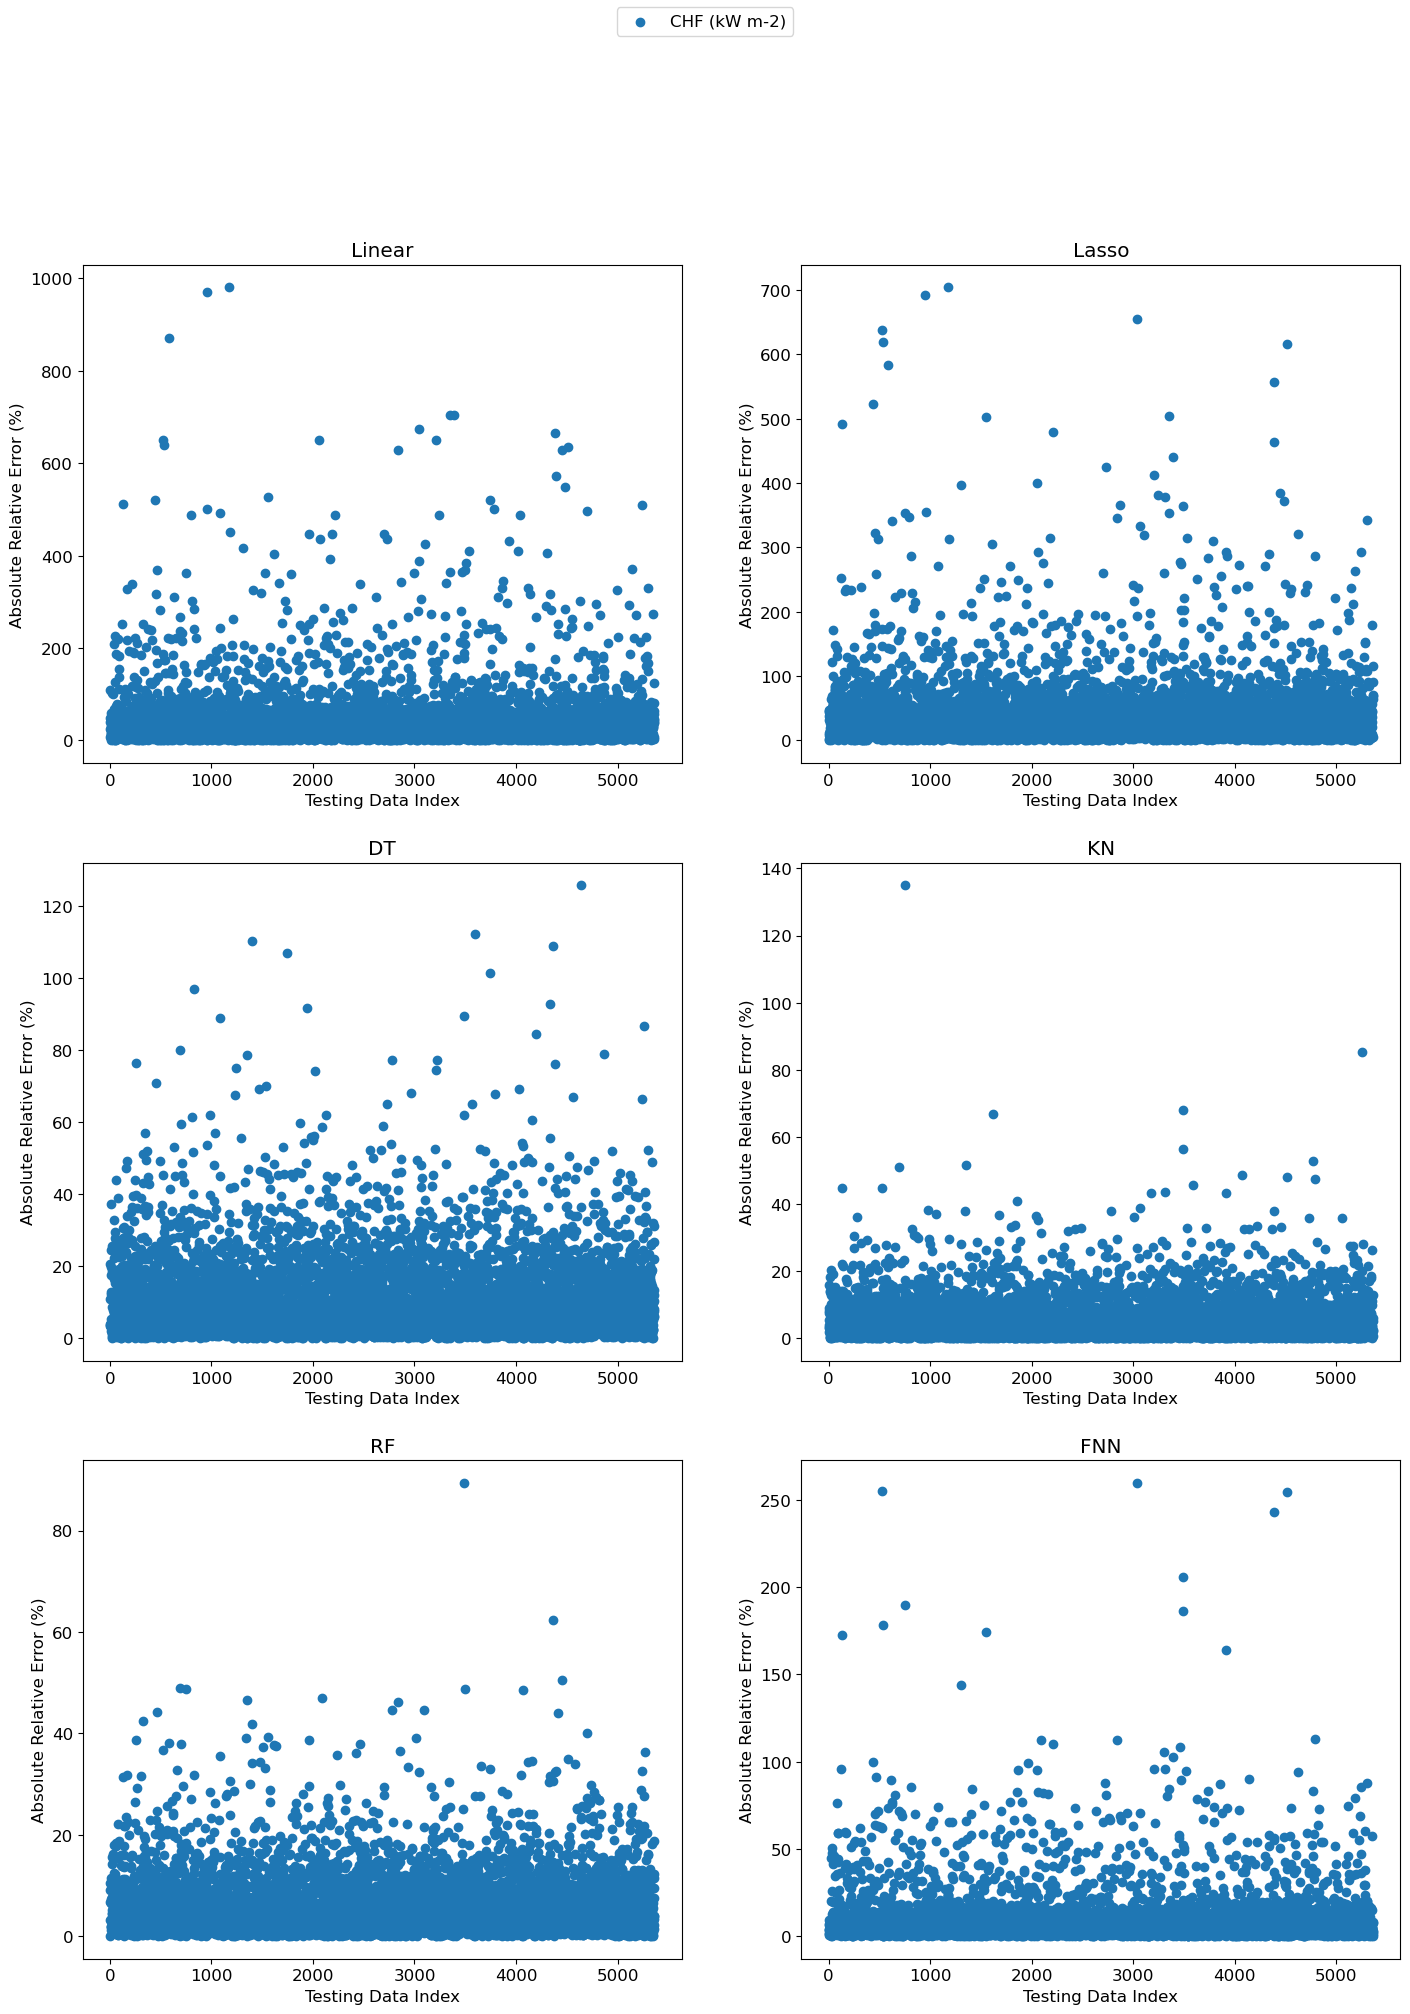

In [18]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["CHF (kW m-2)"]

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])
        

fig.legend(y, loc="upper center", ncol=4)
fig.savefig('error_plot.png', dpi=300, bbox_inches='tight')

The diagonal validation and validation plots agree with the performance metrics. Interestingly, all models increase prediction error as we move radially from the middle of the core.

To further understand the behavior of the top neural network configurations, we can plot the learning curve. Here, the top neural network learning curve is shown but, similar to the diagonal and validation plot functions, `pyMAISE.PostProcessor.nn_learning_plot` shows the neural network based on the index in `pyMAISE.PostProcessor.metrics` or, if no index is provided, the one with the best test $R^2$.

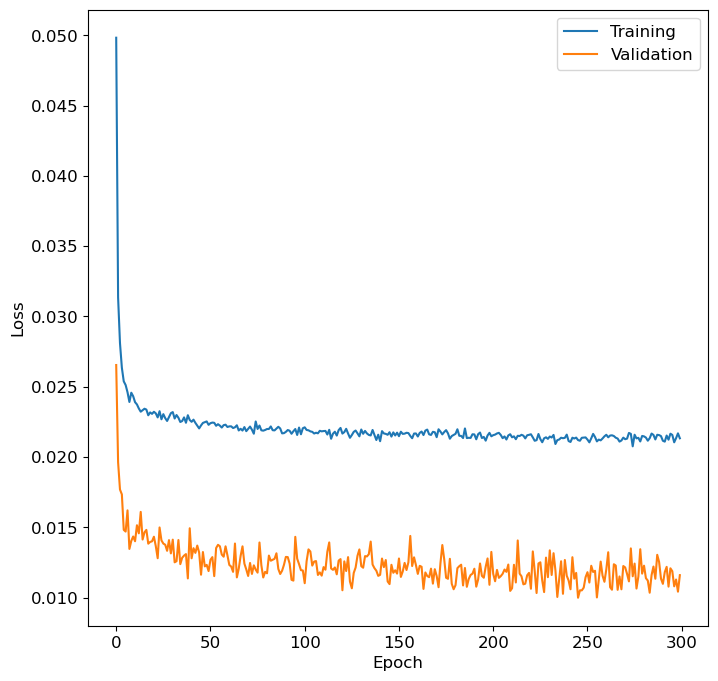

In [19]:
postprocessor.nn_learning_plot()
plt.savefig('nn_learning.png', dpi=300, bbox_inches='tight')

The FNN is not overfitting, as the validation curve closely follows the training curve.

Finally, using the best FNN model, we can generate a predicted power for each fuel element given the control blade heights. This code block retrieves the top-performing model using the `pyMAISE.PostProcessor.get_model` function.

## Explainability

In [20]:
import pyMAISE.explain._explain as explain

In [21]:
model = postprocessor.get_model(model_type="FNN")

pretty_feature_names = [r"$L$ $[m]$", r"$G$ $[\frac{kg}{m^2s}]$", r"$T_{In}$ $[^{\circ}C]$", r"$D$ $[m]$", r"$X_e$ $[-]$", r"$P$ $[kPa]$"]
# Define our Explainability Object
e = explain.ShapExplainers(model, Xtrain=xtrain.values, Xtest=xtest.values, 
                   feature_names=pretty_feature_names, 
                   output_names=output_names)

# Calculate shap values using all 3 methods
n=20
e.KernelSHAP(n_background_samples=n,
             n_test_samples=n,
             n_bootstrap=n)
e.DeepLIFT(nsamples=n)
e.IntGradients(nsamples=n)

# Get mean and std for shap summary plot
e.postprocess_results()

# Make plots for all outputs and methods
e.plot()

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

13/13 [==============================] - 0s 605us/step


/home/npanczyk/pyMAISE/pyMAISE/explain/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/npanczyk/pyMAISE/pyMAISE/explain/shap/explainers/_deep/deep_tf.py:153: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn(
/home/npanczyk/miniconda3/envs/maise/lib/python3.11/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


ValueError: 
['$L$ $[m]$', '$G$ $[\\frac{kg}{m^2s}]$', '$T_{In}$ $[^{\\circ}C]$', '$D$ $[m]$', '$X_e$ $[-]$', '$P$ $[kPa]$']
                   ^
ParseException: Expected end of text, found '$'  (at char 19), (line:1, col:20)

Error in callback <function _draw_all_if_interactive at 0x789e1c33e700> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
['$L$ $[m]$', '$G$ $[\\frac{kg}{m^2s}]$', '$T_{In}$ $[^{\\circ}C]$', '$D$ $[m]$', '$X_e$ $[-]$', '$P$ $[kPa]$']
                   ^
ParseException: Expected end of text, found '$'  (at char 19), (line:1, col:20)

ValueError: 
['$L$ $[m]$', '$G$ $[\\frac{kg}{m^2s}]$', '$T_{In}$ $[^{\\circ}C]$', '$D$ $[m]$', '$X_e$ $[-]$', '$P$ $[kPa]$']
                   ^
ParseException: Expected end of text, found '$'  (at char 19), (line:1, col:20)

<Figure size 1800x600 with 3 Axes>

In [57]:
!python --version

Python 3.11.5


In [61]:
from dill import loads, dumps, dump

In [63]:
fpath = "shap_raw.pkl"
with open(fpath, "wb") as file:
    dump(e.shap_raw, file)

In [65]:
dir(e)

['DeepLIFT',
 'IntGradients',
 'KernelSHAP',
 'Xtest',
 'Xtrain',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'deep_lift',
 'feature_names',
 'ig',
 'kernel_e',
 'mega_plot',
 'model',
 'n_features',
 'n_outputs',
 'output_names',
 'plot',
 'postprocess_results',
 'shap_mean',
 'shap_raw',
 'shap_samples',
 'shap_std']

In [55]:
e.shap_raw

{'KernelSHAP': array([[[-1.51531024e-02],
         [ 6.13494170e-02],
         [ 4.48509629e-04],
         [ 1.11172989e-01],
         [ 6.76593695e-02],
         [ 1.60757482e-02]],
 
        [[-6.24374900e-03],
         [ 6.02681477e-02],
         [ 4.53011601e-03],
         [ 4.43462249e-02],
         [-2.08309856e-02],
         [-3.55957654e-03]],
 
        [[-6.99321522e-03],
         [-9.19656944e-02],
         [ 4.85711083e-04],
         [ 3.40763789e-02],
         [-2.00099800e-02],
         [-7.83319757e-03]],
 
        [[-2.66493780e-02],
         [ 4.17854079e-02],
         [ 1.81435494e-02],
         [-4.91354598e-02],
         [ 4.87246841e-02],
         [-1.59242636e-02]],
 
        [[-4.89390791e-03],
         [ 3.86182298e-02],
         [ 1.60576833e-03],
         [-3.20721152e-02],
         [ 2.10396737e-02],
         [-6.54840137e-03]],
 
        [[ 2.34781556e-02],
         [-2.85299500e-02],
         [ 3.45485333e-03],
         [ 5.49952956e-02],
         [ 1.684284

In [51]:
plt.rcParams['text.usetex'] = True

In [52]:
pretty_feature_names = [r"$L$ $[m]$", r"G", r"$T_{In}$ $^\circ C$", r"$D$ $[m]$", r"$X_e$ $[-]$", r"$P$ $[kPa]$"]
e.feature_names = pretty_feature_names
e.feature_names

['$L$ $[m]$',
 'G',
 '$T_{In}$ $^\\circ C$',
 '$D$ $[m]$',
 '$X_e$ $[-]$',
 '$P$ $[kPa]$']

In [53]:
e.plot()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x789e1c33e700> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1800x600 with 3 Axes>

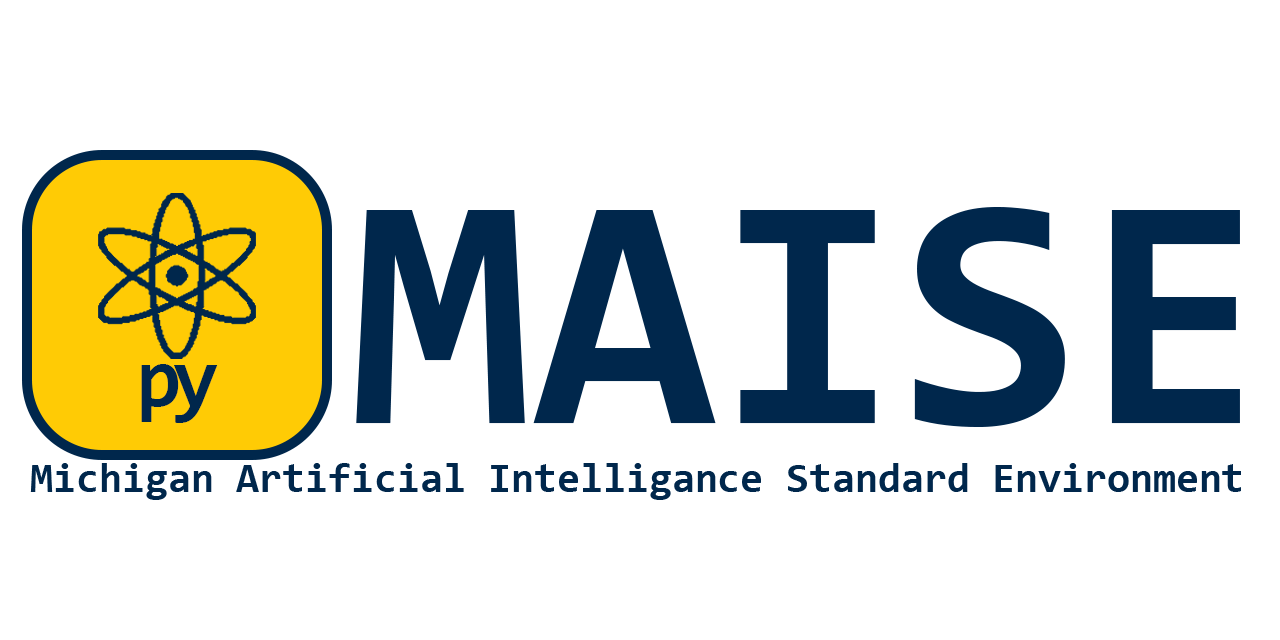